# Node classification with Node2Vec


In [4]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1 --ignore-requires-python

In [32]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph #feel free to use any other library of your choice
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [6]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


node2vec:

In [11]:
# walks = get random walks using BiasedRandomWalk
#experiment with the hyperparamenters
num_walks = 100
num_steps = 10
return_prob = 0.1
away_prob = 0.1

a = BiasedRandomWalk(G)

walks = a.run(nodes=list(G.nodes()), n=num_walks, length=num_steps, p=return_prob, q=away_prob)
#walks = BiasedRandomWalk(G, n=num_walks, length=num_steps, p=return_prob, q=away_prob)


In [44]:
# from gensim.models import Word2Vec

# str_walks = [[str(n) for n in walk] for walk in walks]
# model = Word2Vec(str_walks, ) #check which parameter are important

from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
sg = 1 #defines the training algorithms; default = 0 = CBOW, 1 = skip-gram
size = 1433 #dimensionality of the feature vectors
window = 5 #maximum distance between the current and predicted word within a sentence
alpha = 0.1 #initial learning rate (will linearly drop to 'min_alpha' as training progresses)
min_count =  1 #ignore all the words with total frequency lower than this
sample = 1e-2 #threshold for configuring which higher-frequency words are randomly sampled; default = 1e-3, range is (0, 1e-5)
#workers; don't have multicore so irrelevant
iter = 1 #number of iterations (epochs) over the corpus; default = 5

model = Word2Vec(str_walks, sg=sg, vector_size=size, window=window, alpha=alpha, min_count = min_count, sample=sample, epochs = iter ) #check which parameter are important

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
#model.wv["19231"].shape

visualize

In [45]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [46]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

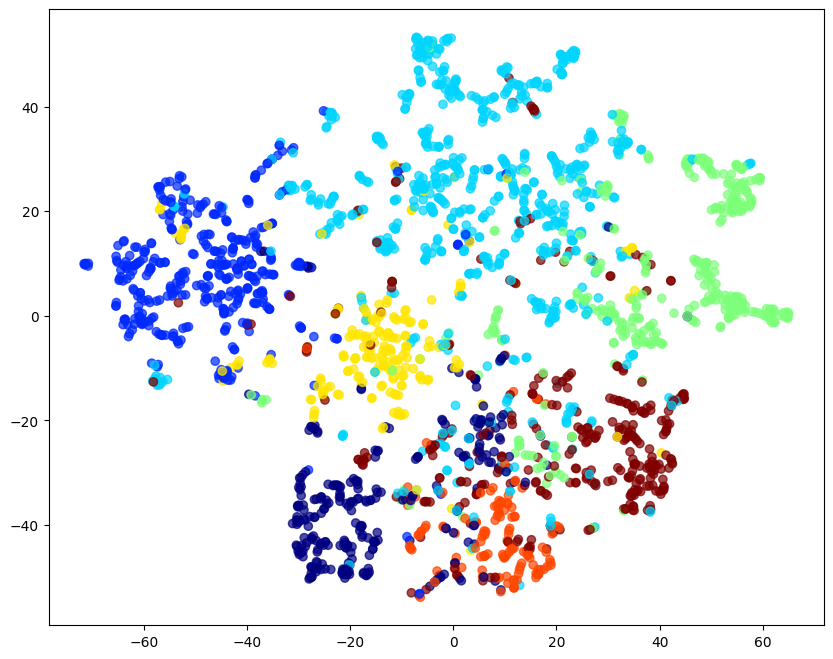

In [47]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

CORA classification

In [50]:
#X = None
#y = None
#split the data. use 140 examples in train set


X = node_embeddings
y = np.array(node_targets)

b = KFold(n_splits=2, random_state=None, shuffle=False)
#for i, (train_index, test_index) in enumerate(b.split(X)):
#  print(f"Fold {i}:")
#  print(f" Train: index= {train_index}")
#  print(f" Test: index={test_index}")

x_train = X[:140]
x_test = X[140:]

y_train = y[:140]
y_test = y[140:]

#clf = classifier, use kfold cross validation
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

clf = RandomForestClassifier()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

#get accuracy, classification report

accuracy_score(y_test, y_pred)

0.7347547974413646

In [51]:
print(y)

['Genetic_Algorithms' 'Neural_Networks' 'Neural_Networks' ...
 'Reinforcement_Learning' 'Genetic_Algorithms' 'Reinforcement_Learning']


In [29]:
print(len(x_test))
print(node_embeddings)
print(len(node_embeddings[0]))
print(b)

2345
[[-0.34964752 -0.23555985 -0.12505837 ...  0.10893474  0.20225395
   0.14553906]
 [-0.3304551   0.13344479  0.40828484 ... -0.25285354 -0.4313311
  -0.15779312]
 [ 0.31250942 -0.07185104 -0.11282331 ...  0.20221575  0.17032094
  -0.20552455]
 ...
 [ 0.2070085  -0.4296771   0.18350162 ... -0.27717194  0.34306923
   0.36957166]
 [-0.03034828 -0.01835077 -0.23117638 ... -0.03091685  0.26245245
   0.13887241]
 [-0.42143032  0.15475595 -0.19971414 ... -0.5852318   0.14020313
  -0.02029803]]
100
KFold(n_splits=2, random_state=None, shuffle=False)


In [162]:

all_data = []
all_edges = []

with open("cora.content",'r') as f:
  all_data.extend(f.read().splitlines())
with open("cora.cites",'r') as f:
  all_edges.extend(f.read().splitlines())

#parse the data
labels = []
nodes = []
Z = []
element_to_ind  = {}

for i,data in enumerate(all_data):
    elements = data.split('\t')
    if elements[0] in node_ids:
      labels.append(elements[-1])
      Z.append(elements[1:-1])
      nodes.append(elements[0])
      element_to_ind[elements[0]]= i
Z = np.array(Z,dtype=int)
N = Z.shape[0] #the number of nodes
F = Z.shape[1] #the size of node features
print('Z shape: ', Z.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))



Z shape:  (2485, 1433)


In [163]:
print(nodes)

['31336', '1061127', '1106406', '13195', '37879', '1126012', '1107140', '1102850', '31349', '1106418', '1123188', '1128990', '109323', '217139', '31353', '32083', '1126029', '1118017', '49482', '753265', '249858', '1113739', '48766', '646195', '1126050', '59626', '340299', '354004', '242637', '1106492', '74975', '1152272', '100701', '66982', '13960', '13966', '66990', '182093', '182094', '13972', '13982', '16819', '273152', '237521', '1153703', '32872', '284025', '218666', '16843', '1153724', '1153728', '158098', '8699', '1134865', '28456', '248425', '1112319', '28471', '175548', '696345', '28485', '35778', '28491', '310530', '1153784', '1481', '1153786', '13212', '1111614', '5055', '4329', '330148', '1105062', '4330', '5062', '4335', '158812', '40124', '1103610', '688361', '20534', '1031453', '5086', '193742', '424', '40151', '636098', '260121', '950052', '434', '1131270', '1131274', '1131277', '1110947', '662279', '1139928', '153063', '134199', '641956', '20584', '1130567', '171225',

In [164]:
df = pd.DataFrame(list(zip(nodes, labels,Z)),columns =['node', 'label','features'])
df.head()

,node,label,features
0,31336,Neural_Networks,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1061127,Rule_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,1106406,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,13195,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,37879,Probabilistic_Methods,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [165]:
sorted_df = df.sort_values(by='node', key = lambda x: x.map(dict(zip(node_ids, range(len(node_ids))))))

In [166]:
sorted_df.head()

,node,label,features
159,35,Genetic_Algorithms,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
702,1365,Neural_Networks,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
402,3229,Neural_Networks,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
533,6213,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
575,910,Neural_Networks,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [167]:
print(sorted_df['features'])

159     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
702     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
402     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
533     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
575     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
2301    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
719     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
689     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
514     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1497    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: features, Length: 2485, dtype: object


In [168]:
testest = [item for item in sorted_df['features']]
print(testest)

[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 1, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([

In [169]:
sorted_labels = []
sorted_features = []
for i in range(sorted_df.shape[0]):
  temp = sorted_df.iloc[i]
  sorted_labels.append(temp[1])
  sorted_features.append(temp[2])


In [150]:
sorted_features2 = []
for item in sorted_features:
  sorted_features2.append(item)

In [170]:
print(len(sorted_labels))

2485


In [178]:
#X = None
#y = None
#split the data. use 140 examples in train set

c = KFold(n_splits=2, random_state=None, shuffle=False)
#for i, (train_index, test_index) in enumerate(b.split(X)):
#  print(f"Fold {i}:")
#  print(f" Train: index= {train_index}")
#  print(f" Test: index={test_index}")

z_train = sorted_features[:140]
z_test = sorted_features[140:]

labels_train = sorted_labels[:140]
labels_test = sorted_labels[140:]

#clf = classifier, use kfold cross validation
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

#clf = RandomForestClassifier()
clf.fit(z_train, labels_train)
labels_pred = clf.predict(z_test)

#get accuracy, classification report

accuracy_score(labels_test, labels_pred)

0.5411513859275053

In [174]:
print(sorted_labels)
print(y)

['Genetic_Algorithms', 'Neural_Networks', 'Neural_Networks', 'Reinforcement_Learning', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Neural_Networks', 'Theory', 'Theory', 'Case_Based', 'Rule_Learning', 'Theory', 'Neural_Networks', 'Genetic_Algorithms', 'Reinforcement_Learning', 'Reinforcement_Learning', 'Theory', 'Genetic_Algorithms', 'Theory', 'Theory', 'Case_Based', 'Theory', 'Theory', 'Neural_Networks', 'Neural_Networks', 'Neural_Networks', 'Genetic_Algorithms', 'Probabilistic_Methods', 'Rule_Learning', 'Case_Based', 'Theory', 'Probabilistic_Methods', 'Probabilistic_Methods', 'Probabilistic_Methods', 'Genetic_Algorithms', 'Rule_Learning', 'Probabilistic_Methods', 'Theory', 'Genetic_Algorithms', 'Theory', 'Reinforcement_Learning', 'Genetic_Algorithms', 'Neural_Networks', 'Neural_Networks', 'Case_Based', 'Rule_Learning', 'Neural_Networks', 'Neural_Networks', 'Probabilistic_Methods', 'Theory', 'Probabilistic_Methods', 'Probabilistic_Methods', 'Probabilistic_Met

In [177]:
avg_features = (sorted_features + X)/2

avg_train = avg_features[:140]
avg_test = avg_features[140:]

clf.fit(avg_train, y_train)
avg_pred = clf.predict(avg_test)

accuracy_score(y_test, avg_pred)


0.7279317697228145